<a href="https://colab.research.google.com/github/AlephEleven/Parameter-Space-Optimization/blob/main/Parameter_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Space Optimization

The inspiration for using a parameter space to visualize weights/bias comes from https://www.youtube.com/watch?v=my3lsV-VQjs.

This technique takes advantage of calculating nearby errors for a function's respective weights/bias, to try to optimize a function using a pseudo "gradient descent", based on following the smallest neighbor.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [ ]:
X = np.linspace(0, 10, 100)
Y = 2*X
rands = np.random.randn(X.size)
Y += rands

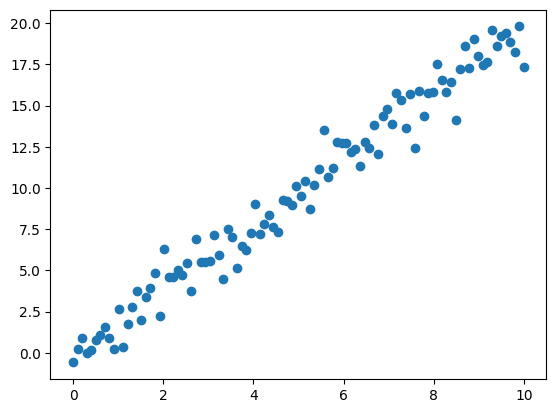

In [ ]:
plt.scatter(X, Y)

# 1) Parameter Space

Contour graph of errors, where each (x,y) point corresponds to a (weight, bias), such that the goal is to find coordinates with the minimum error

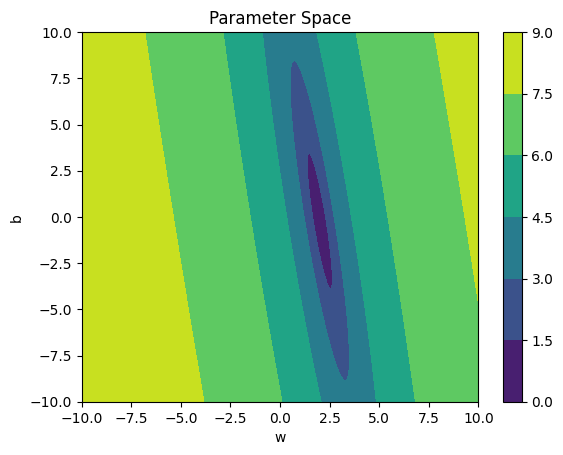

In [ ]:
def E(X, Y, w, b, active = lambda x: x):
  y_pred = active(w*X + b)
  return np.sum((Y - y_pred)**2)/X.size

def plot_param_space(X, Y, error, activation, N = 200, max = 10, min = -10, log_vals=True, C = np.array([])):
  W = np.linspace(min, max, N)
  B = np.linspace(min, max ,N)

  if C.size != 0:
    ZZ = np.array([[error(X, Y, w_space, b_space, activation, C) for w_space in W] for b_space in B])
  else:
    ZZ = np.array([[error(X, Y, w_space, b_space, activation) for w_space in W] for b_space in B])

  if log_vals:
    ZZ = np.log(ZZ)

  plt.contourf(W, B, ZZ)
  plt.colorbar()

  plt.xlabel("w")
  plt.ylabel("b")
  plt.title("Parameter Space")

plot_param_space(X, Y, E, lambda x: x)
plt.show()

As shown above, the optimal point corresponds with our Y = 2*X, where weight = 2, bias = 0

# 2) Parameter Space Optimization

Based on the idea of viewing a parameter space, we can write an optimization algorithm similar to gradient descent, which views surrounding points and moves towards the lowest error until it minimizes it.

In [ ]:
class ParameterSpaceOptimize:

  def __init__(self, error, activation, init_lr = 0.5, num_grids = 3, max_iters = 100, early_stopping = 1e-2, min_iters = 10):
    self.error_ = error
    self.activation_ = activation
    self.lr = init_lr
    self.num_grids_ = num_grids
    self.max_iters = max_iters
    self.min_iters = min_iters
    self.early_stopping = early_stopping

    self.w_ = np.random.randn(1)
    self.b_ = np.array([1e-1])

  def fit(self, X, Y, C=np.array([])):
    '''
    Learn a pair of (X, Y) data by looking at a range of the parameter space from the original weights
    Then move towards the direction of least error

    Returns weight/bias history and last iteration ran
    '''

    w_hist = []
    b_hist = []
    min_error = 0

    for ind in range(self.max_iters):
      w_hist += [self.w_]
      b_hist += [self.b_]


      adjust = ((param_space.min()/min_error)**2)*(self.max_iters-ind)/self.max_iters if ind > 1 else 1

      W_grid = np.linspace(self.w_ + self.lr*adjust, self.w_ - self.lr*adjust, self.num_grids_)
      B_grid = np.linspace(self.b_ + self.lr*adjust, self.b_ - self.lr*adjust ,self.num_grids_)

      if C.size != 0:
        param_space = np.array([[self.error_(X, Y, w_space, b_space, self.activation_, C=C) for w_space in W_grid] for b_space in B_grid])
      else:
        param_space = np.array([[self.error_(X, Y, w_space, b_space, self.activation_) for w_space in W_grid] for b_space in B_grid])

      index = np.argmin(param_space.reshape(-1).argsort())

      min_error = param_space.min()
      if ((ind+1)%(self.max_iters//10) == 0):
        print(f"Iteration {ind+1},  Error: {min_error}, Adjust: {adjust}")


      W_index = index//self.num_grids_
      B_index = index%self.num_grids_

      self.w_ = W_grid[W_index]
      self.b_ = B_grid[B_index]

      if (min_error < self.early_stopping) and ind > self.min_iters:
        print(f"Stopped at Iteration {ind+1} with error of {min_error}")
        break

    return np.array(w_hist), np.array(b_hist), ind



  



## 2.1) Linear Regression(ish)

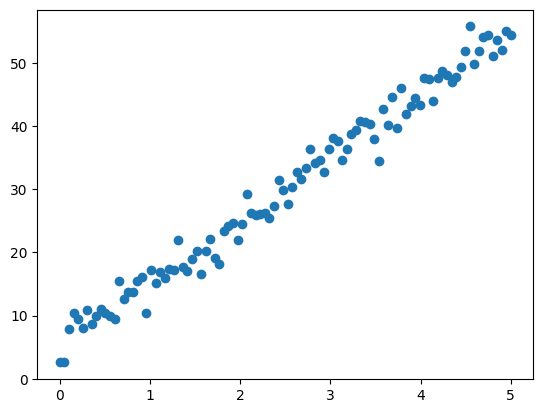

In [ ]:
X = np.linspace(0, 5, 100)
Y = 10*X+5
rands = np.random.randn(X.size)*2
Y += rands

plt.scatter(X, Y)
plt.show()

In [ ]:
fn = lambda x: x

model = ParameterSpaceOptimize(E, fn, init_lr = 1,
                                           max_iters = 100,
                                           num_grids=5, 
                                           early_stopping= 1e-2)

w_hist, b_hist, max_iterations = model.fit(X, Y)

Iteration 10,  Error: 6.508444212508407, Adjust: 0.91
Iteration 20,  Error: 4.148824711137579, Adjust: 0.81
Iteration 30,  Error: 4.559111283830832, Adjust: 0.71
Iteration 40,  Error: 4.145537669564224, Adjust: 0.61
Iteration 50,  Error: 4.121315863964469, Adjust: 0.51
Iteration 60,  Error: 4.096521975217015, Adjust: 0.41
Iteration 70,  Error: 4.095431665071683, Adjust: 0.31
Iteration 80,  Error: 4.098593818313174, Adjust: 0.21
Iteration 90,  Error: 4.095107675151497, Adjust: 0.11
Iteration 100,  Error: 4.094868817975927, Adjust: 0.01


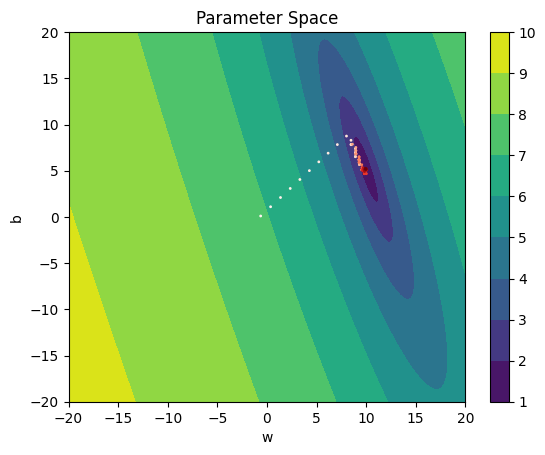

In [ ]:
plot_param_space(X, Y, E, fn, N=250, min=-20, max=20)
plt.scatter(w_hist, b_hist, s=1, c=np.arange(max_iterations+1)/(max_iterations+1), cmap = 'Reds')
plt.show()

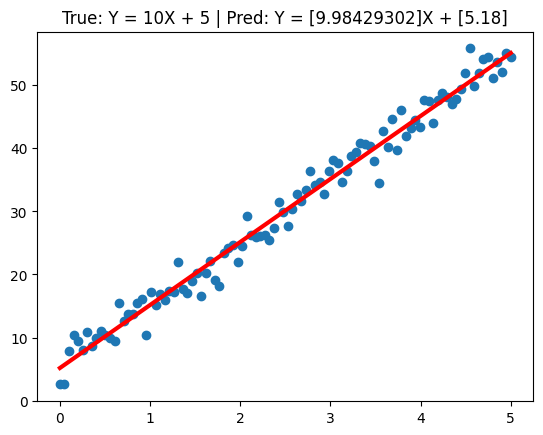

In [ ]:
plt.scatter(X, Y)
plt.plot(X, fn(model.w_*X + model.b_), c='r', linewidth=3)
plt.title(f"True: Y = 10X + 5 | Pred: Y = {model.w_}X + {model.b_}")
plt.show()

## 2.2) Sigmoid

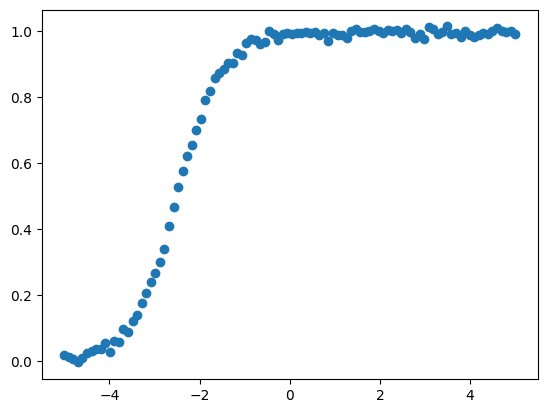

In [ ]:
X = np.linspace(-5, 5, 100)
Y = sigmoid(2*X+5)
rands = np.random.randn(X.size)/100
Y += rands

plt.scatter(X, Y)
plt.show()

In [ ]:
fn = sigmoid

model = ParameterSpaceOptimize(E, fn, init_lr = .5,
                                           max_iters = 500,
                                           num_grids=10, 
                                           early_stopping= 1e-4)

w_hist, b_hist, max_iterations = model.fit(X, Y)

Iteration 50,  Error: 0.00018864814291933666, Adjust: 0.902
Iteration 100,  Error: 0.00013295497213179896, Adjust: 0.802
Iteration 150,  Error: 0.00011839612723468638, Adjust: 0.702
Iteration 200,  Error: 0.00016171029658770808, Adjust: 0.602
Iteration 250,  Error: 0.00011839160922465254, Adjust: 0.502
Iteration 300,  Error: 0.00012148781833638035, Adjust: 0.402
Iteration 350,  Error: 0.00025200105205168367, Adjust: 0.302
Iteration 400,  Error: 0.00014947677278124896, Adjust: 0.202
Iteration 450,  Error: 0.00011480699174486089, Adjust: 0.102
Iteration 500,  Error: 0.00011115076975532943, Adjust: 0.002


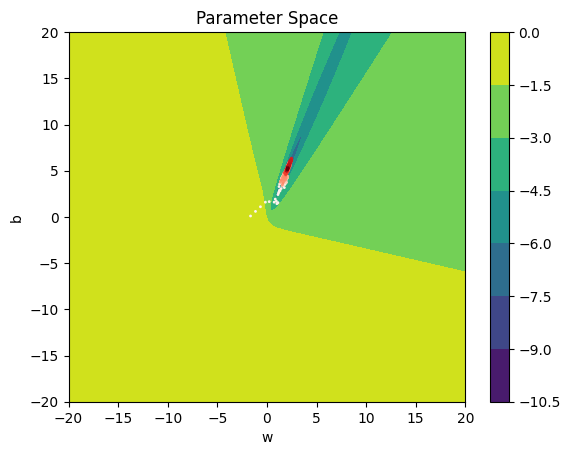

In [ ]:
plot_param_space(X, Y, E, fn, N=250, min=-20, max=20)
plt.scatter(w_hist, b_hist, s=1, c=np.arange(max_iterations+1)/(max_iterations+1), cmap = 'Reds')
plt.show()

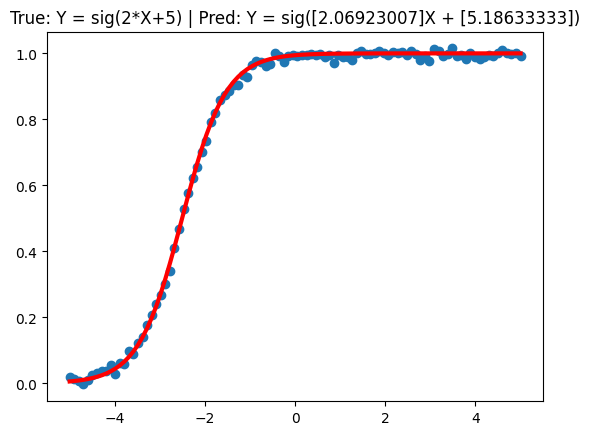

In [ ]:
plt.scatter(X, Y)
plt.plot(X, fn(model.w_*X + model.b_), c='r', linewidth=3)
plt.title(f"True: Y = sig(2*X+5) | Pred: Y = sig({model.w_}X + {model.b_})")
plt.show()

## 2.3) Classification (SVM-ish)

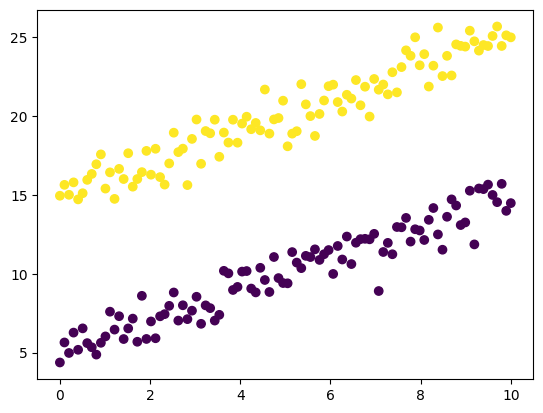

In [ ]:
lin = np.linspace(0, 10, 100)

X = np.hstack((lin, lin))
Y = np.hstack((lin+5, lin+15))
C = np.hstack((np.zeros(100), np.ones(100)))
rands = np.random.randn(X.size)
Y += rands

plt.scatter(X, Y, c = C)
plt.show()

In [ ]:
def E_margin(X, Y, w, b, active = lambda x: x, C=None):
  y_hat = active(w*X + b)
  y_pred = (Y - y_hat >= 0) == C

  return np.sum(np.abs(y_pred*(Y - y_hat))**2)/X.size


In [ ]:
E_margin(X, Y, 1, 10, C=C)

25.92447578922957

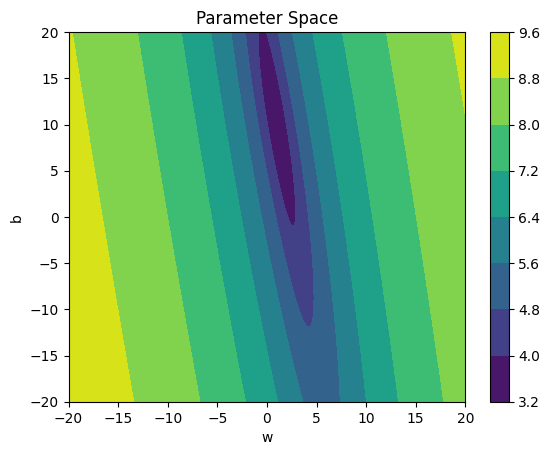

In [ ]:
plot_param_space(X, Y, E_margin, fn, N=250, min=-20, max=20, log_vals=True, C=C)
plt.show()

In [ ]:
fn = lambda x: x

model = ParameterSpaceOptimize(E_margin, fn, init_lr = 3,
                                           max_iters = 1000,
                                           num_grids=10, 
                                           early_stopping= 1e-3)

w_hist, b_hist, max_iterations = model.fit(X, Y, C)

Iteration 100,  Error: 36.40183050573592, Adjust: 0.901
Iteration 200,  Error: 34.32138631139486, Adjust: 0.801
Iteration 300,  Error: 32.475905484676275, Adjust: 0.701
Iteration 400,  Error: 30.9048562950387, Adjust: 0.601
Iteration 500,  Error: 29.47565062252428, Adjust: 0.501
Iteration 600,  Error: 28.28412302167534, Adjust: 0.401
Iteration 700,  Error: 27.370241473124626, Adjust: 0.301
Iteration 800,  Error: 26.682716111494436, Adjust: 0.201
Iteration 900,  Error: 26.207885364933574, Adjust: 0.101
Iteration 1000,  Error: 25.96997465541072, Adjust: 0.001


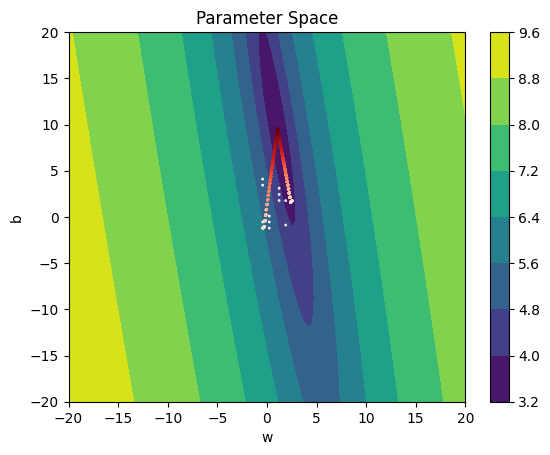

In [ ]:
plot_param_space(X, Y, E_margin, fn, N=250, min=-20, log_vals=True, max=20, C=C)
plt.scatter(w_hist, b_hist, s=1, c=np.arange(max_iterations+1)/(max_iterations+1), cmap = 'Reds')
plt.show()

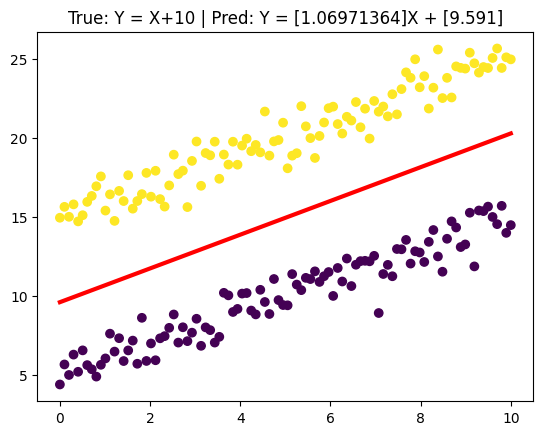

In [ ]:
colors = (Y - fn(model.w_*X + model.b_)) >= 0
plt.scatter(X, Y, c = colors)
plt.plot(X, fn(model.w_*X + model.b_), c='r', linewidth=3)
plt.title(f"True: Y = X+10 | Pred: Y = {model.w_}X + {model.b_}")
plt.show()

# 3) Conclusion

Parameter space optimization is a visually great technique, and works very well (given the right hyper-parameters) for any problem involving min/maximization. However, the major downside is that the algorithm becomes exponentially more expensive for each new parameter, since the algorithm relies on finding the smallest value in its range. One important takeaway is that it helps give a different perspective of gradient descent optimization by using a naive but easily understandable algorithm that follows the similar principles of finding a minimal error with respect to weight/bias.

The results above show that this optimization technique can work very well, but for some problems may need hyper-parameter tuning due to the sharp decrease in "momentum" when the algorithm is closer to the maximum iterations.